In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Concatenate , Add, Dot, Activation, Lambda, BatchNormalization, LeakyReLU, Softmax
from tensorflow.keras.models import Model

from tensorflow.image import flip_up_down, flip_left_right, rot90
from tensorflow.linalg import normalize

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import math

import matplotlib.pyplot as plt
import sys 
sys.path.append('..')
from layers.sorted_filters import SortedConv2D

import datetime


In [2]:
from tensorflow.python.client import device_lib
#tf.disable_v2_behavior()

#print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

print(tf.__version__ )

Num GPUs Available:  1
2.9.1


In [3]:
input_net = Input((32, 32, 3))

y = SortedConv2D(filters=16,activation=LeakyReLU(alpha=0.1), padding='SAME')(input_net)
y = layers.MaxPooling2D(pool_size=(2, 2))(y) 
y = layers.BatchNormalization(axis=-1)(y)
y = layers.Dropout(0.)(y)


y = SortedConv2D(filters=32,activation=LeakyReLU(alpha=0.1), padding='SAME')(y)
y = SortedConv2D(filters=32,activation=LeakyReLU(alpha=0.1), padding='SAME')(y)
y = layers.MaxPooling2D(pool_size=(2, 2))(y) 
y = layers.BatchNormalization(axis=-1)(y)
y = layers.Dropout(0.5)(y)

y = SortedConv2D(filters=64, activation=LeakyReLU(alpha=0.1), padding='SAME')(y)
y = SortedConv2D(filters=64, activation=LeakyReLU(alpha=0.1), padding='SAME')(y)
y = SortedConv2D(filters=64, activation=LeakyReLU(alpha=0.1), padding='SAME')(y)
y = layers.MaxPooling2D(pool_size=(2, 2))(y)
y = layers.BatchNormalization(axis=-1)(y)
y = layers.Dropout(0.5)(y)

y = layers.Flatten()(y)
y = layers.BatchNormalization()(y)
y = layers.Dense(512, activation=LeakyReLU(alpha=0.1))(y)
y = layers.BatchNormalization(axis=-1)(y)
y = layers.Dropout(0.2)(y)
output_net  = layers.Dense(100, activation=Softmax())(y)

model = Model(inputs = input_net, outputs = output_net)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sorted_conv2d (SortedConv2D  (None, 32, 32, 16)       162       
 )                                                               
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 16)       64        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 16, 16, 16)        0         
                                                             

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


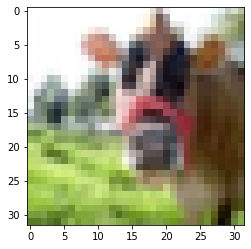

In [4]:
num_classes = 100
input_shape = (32, 32, 3)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()



# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
#x_train = np.expand_dims(x_train, -1)
#x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

plt.imshow(x_train[0,:,:,:])

In [5]:
model = Model(inputs = input_net, outputs = output_net)

initial_learning_rate =  0.01

lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate,
    alpha = 0.000001,
    m_mul=1.0,
    first_decay_steps = 20)

optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
)


checkpoint_filepath = "/tmp/checkpoint"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)

batch_size = 256
epochs = 200
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), callbacks=[tensorboard_callback])

Epoch 1/200
196/196 [==============================] - 23s 58ms/step - loss: 4.9764 - accuracy: 0.0461 - top-5-accuracy: 0.1596 - val_loss: 4.7133 - val_accuracy: 0.0197 - val_top-5-accuracy: 0.0818
Epoch 2/200
196/196 [==============================] - 9s 47ms/step - loss: 4.0953 - accuracy: 0.0827 - top-5-accuracy: 0.2551 - val_loss: 4.1733 - val_accuracy: 0.0652 - val_top-5-accuracy: 0.2134
Epoch 3/200
196/196 [==============================] - 9s 47ms/step - loss: 3.8920 - accuracy: 0.1096 - top-5-accuracy: 0.3075 - val_loss: 3.8459 - val_accuracy: 0.1257 - val_top-5-accuracy: 0.3351
Epoch 4/200
196/196 [==============================] - 10s 53ms/step - loss: 3.8508 - accuracy: 0.1106 - top-5-accuracy: 0.3165 - val_loss: 3.9178 - val_accuracy: 0.1039 - val_top-5-accuracy: 0.3070
Epoch 5/200
196/196 [==============================] - 9s 48ms/step - loss: 3.7157 - accuracy: 0.1338 - top-5-accuracy: 0.3571 - val_loss: 3.6730 - val_accuracy: 0.1476 - val_top-5-accuracy: 0.3713
Epoch 6/

KeyboardInterrupt: 

In [ ]:
%tensorboard --logdir logs/fit

UsageError: Line magic function `%tensorboard` not found.


1/1 [==============================] - 0s 490ms/step
[59] 59
(1, 32, 32, 16)
[[-1.0555872  -1.0600044  -1.0584435  ... -1.0556914  -1.0551684
  -1.0366008 ]
 [-1.0701905  -1.0555416  -1.0499995  ... -1.050111   -1.050959
  -1.0412382 ]
 [-1.0687417  -1.0555279  -1.0523694  ... -1.0458878  -1.0475477
  -1.0391608 ]
 ...
 [-0.88622683 -0.88193285 -0.8825614  ... -0.88899916 -0.89078826
  -0.8950862 ]
 [-0.88863844 -0.883193   -0.8839291  ... -0.91899437 -0.92582685
  -0.92752075]
 [-0.8975326  -0.89199173 -0.8912822  ... -0.9214062  -0.93508977
  -0.9390587 ]]


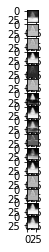

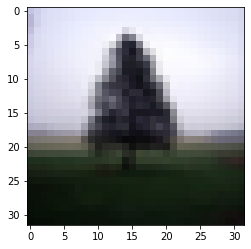

In [ ]:
get_layer_output = K.function([model.input], model.layers[1].output)

n = 109

X = np.expand_dims(x_test[n], axis=0)
print(y_test[n], np.argmax(model.predict(X)))


layer_out = np.array(get_layer_output([X]))
print(layer_out.shape)

print(layer_out[0, :,:, 0])
fig, ax = plt.subplots(16)
for i in range(16):
    ax[i].imshow(layer_out[0, :,:, i],  cmap='gray')   

plt.figure(2)  
plt.imshow(x_test[n],  cmap='gray')   

 

In [ ]:
model.layers[4].trainable_variables[3].name

NameError: name 'model' is not defined

In [ ]:
model.layers[1].scale_s

<tf.Variable 'sorted_conv2d/scale_sym:0' shape=() dtype=float32, numpy=-0.0684901>

In [ ]:
model.layers[1].get_sym_filter(0,3) 

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[ 1.057311  , -0.15671223,  1.057311  ],
       [-0.15671223, -0.23184319, -0.15671223],
       [ 1.057311  , -0.15671223,  1.057311  ]], dtype=float32)>